In [6]:
import numpy as np
import pandas as pd
import xgboost as xgb
import warnings
import os
import matplotlib.pyplot as plt
import seaborn as sns

#设置警告过滤器，这里过滤了将来可能会发生的警告（FutureWarning）。
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

#绘图样式的设置，使用了 seaborn 库，将绘图样式设置为 'seaborn'，并将字体比例设置为1。
plt.style.use('seaborn')
sns.set(font_scale=1)

#设置数据集目录
path  = 'E:\\1.同济大学各学科资料\\3.2 大三年级下学期\\11.专业实习\\专业实习\\code\\HangzhouMetro'
test = pd.read_csv(path + '/Metro_testA/testA_submit_2019-01-29.csv')
test_28 = pd.read_csv(path + '/Metro_testA/testA_record_2019-01-28.csv')
#station_con = pd.read_csv('Metro_roadMap.csv')
test_28

,time,lineID,stationID,deviceID,status,userID,payType
0,2019-01-28 00:00:04,B,33,1587,0,Aad6ad59dfdd470bfdfdb0d2959db068b,0
1,2019-01-28 00:00:04,C,63,2933,0,Bab97d7b32891b8cb5451e80b73b23d70,1
2,2019-01-28 00:00:06,C,63,2934,0,Dda829d9f38d0a28f1e4ae84a34e846dc,3
3,2019-01-28 00:00:06,C,39,1839,0,Cc397069031ab762d75d613291cd68cda,2
4,2019-01-28 00:00:07,B,33,1588,0,Ba83c695d27b4d376bfde3f755e4b677f,1
...,...,...,...,...,...,...,...
2404889,2019-01-28 23:59:55,B,25,1269,0,C41df788a280ab7ea2c2abdfcd316b609,2
2404890,2019-01-28 23:59:55,B,25,1275,0,D24eab2c788a7b6afcbecff458d0239cd,3
2404891,2019-01-28 23:59:57,C,63,2953,0,C0a9ade6c70e9c1b6ef4d24802cb6d0af,2
2404892,2019-01-28 23:59:57,B,2,74,0,B15caccb389f3a72c154c8897d4ab9587,1


In [7]:
test

,stationID,startTime,endTime,inNums,outNums
0,0,2019-01-29 00:00:00,2019-01-29 00:10:00,NaN,NaN
1,0,2019-01-29 00:10:00,2019-01-29 00:20:00,NaN,NaN
2,0,2019-01-29 00:20:00,2019-01-29 00:30:00,NaN,NaN
3,0,2019-01-29 00:30:00,2019-01-29 00:40:00,NaN,NaN
4,0,2019-01-29 00:40:00,2019-01-29 00:50:00,NaN,NaN
...,...,...,...,...,...
11659,80,2019-01-29 23:10:00,2019-01-29 23:20:00,NaN,NaN
11660,80,2019-01-29 23:20:00,2019-01-29 23:30:00,NaN,NaN
11661,80,2019-01-29 23:30:00,2019-01-29 23:40:00,NaN,NaN
11662,80,2019-01-29 23:40:00,2019-01-29 23:50:00,NaN,NaN


In [8]:
#计算真实值与预测值之间的绝对百分比误差的平均值
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

#对原始数据进行处理和计算，提取了一些基本特征，并返回结果数据
#df_：原始数据
#test：待处理的测试数据，与 df_ 具有相同的列。
#time_str：时间字符串，用于处理日期的替换操作。
def get_base_features(df_,test,time_str):
    df = df_.copy()
    df['startTime'] = df['time'].apply(lambda x: x[:15].replace(time_str, '-01-29') + '0:00')
    df = df.groupby(['startTime','stationID']).status.agg(['count', 'sum']).reset_index()
    df = test.merge(df, 'left', ['stationID','startTime'])
    df['time'] = df['startTime'].apply(lambda x: x[:15].replace('-01-29', time_str) + '0:00')
    del df['startTime'],df['endTime']
    # base time
    df['day']     = df['time'].apply(lambda x: int(x[8:10]))
    df['week']    = pd.to_datetime(df['time']).dt.dayofweek + 1
    df['hour']    = df['time'].apply(lambda x: int(x[11:13]))
    df['minute']  = df['time'].apply(lambda x: int(x[14:15]+'0'))
    result = df.copy()
    # in,out
    result['inNums']  = result['sum']
    result['outNums'] = result['count'] - result['sum']
    result['day_since_first'] = result['day'] - 1
    #填充缺失值
    result.fillna(0, inplace=True)
    del result['sum'],result['count']
    return result

time_str = '-01-28'
data1 = get_base_features(test_28,test,time_str)
data1


,stationID,inNums,outNums,time,day,week,hour,minute,day_since_first
0,0,0.0,1.0,2019-01-28 00:00:00,28,1,0,0,27
1,0,0.0,2.0,2019-01-28 00:10:00,28,1,0,10,27
2,0,0.0,0.0,2019-01-28 00:20:00,28,1,0,20,27
3,0,0.0,0.0,2019-01-28 00:30:00,28,1,0,30,27
4,0,0.0,0.0,2019-01-28 00:40:00,28,1,0,40,27
...,...,...,...,...,...,...,...,...,...
11659,80,0.0,12.0,2019-01-28 23:10:00,28,1,23,10,27
11660,80,0.0,13.0,2019-01-28 23:20:00,28,1,23,20,27
11661,80,4.0,15.0,2019-01-28 23:30:00,28,1,23,30,27
11662,80,2.0,4.0,2019-01-28 23:40:00,28,1,23,40,27


In [9]:
###29号时间等信息是本身的，inNums和outNums用的28号的数据
###后面也就可以直接将29号作为测试集
time_str = '-01-29'
df = pd.read_csv(path + '/Metro_testA/testA_record_2019-01-28.csv')
df['time'] = df['time'].apply(lambda x: x[:15].replace('-01-28', time_str)+ '0:00')
df = get_base_features(df,test,time_str)
data1 = pd.concat([data1, df], axis=0, ignore_index=True)
data1

,stationID,inNums,outNums,time,day,week,hour,minute,day_since_first
0,0,0.0,1.0,2019-01-28 00:00:00,28,1,0,0,27
1,0,0.0,2.0,2019-01-28 00:10:00,28,1,0,10,27
2,0,0.0,0.0,2019-01-28 00:20:00,28,1,0,20,27
3,0,0.0,0.0,2019-01-28 00:30:00,28,1,0,30,27
4,0,0.0,0.0,2019-01-28 00:40:00,28,1,0,40,27
...,...,...,...,...,...,...,...,...,...
23323,80,0.0,12.0,2019-01-29 23:10:00,29,2,23,10,28
23324,80,0.0,13.0,2019-01-29 23:20:00,29,2,23,20,28
23325,80,4.0,15.0,2019-01-29 23:30:00,29,2,23,30,28
23326,80,2.0,4.0,2019-01-29 23:40:00,29,2,23,40,28


In [10]:
#对指定路径下的每个 csv 文件进行处理和特征提取，并将提取的结果合并到 data1 中。最终得到的 data1 包含了所有文件的特征提取结果。
data_list = os.listdir(path+'/Metro_train/')
for i in range(0, len(data_list)):
    if data_list[i].split('.')[-1] == 'csv':
        time_str = data_list[i].split('.')[0][11:17]
        print(data_list[i], i)
        df = pd.read_csv(path+'/Metro_train/' + data_list[i])
        df = get_base_features(df,test,time_str)
        data1 = pd.concat([data1, df], axis=0, ignore_index=True)
    else:
        continue



record_2019-01-01.csv 0
record_2019-01-02.csv 1
record_2019-01-03.csv 2
record_2019-01-04.csv 3
record_2019-01-05.csv 4
record_2019-01-06.csv 5
record_2019-01-07.csv 6
record_2019-01-08.csv 7
record_2019-01-09.csv 8
record_2019-01-10.csv 9
record_2019-01-11.csv 10
record_2019-01-12.csv 11
record_2019-01-13.csv 12
record_2019-01-14.csv 13
record_2019-01-15.csv 14
record_2019-01-16.csv 15
record_2019-01-17.csv 16
record_2019-01-18.csv 17
record_2019-01-19.csv 18
record_2019-01-20.csv 19
record_2019-01-21.csv 20
record_2019-01-22.csv 21
record_2019-01-23.csv 22
record_2019-01-24.csv 23
record_2019-01-25.csv 24


In [11]:
# 计算进站出站客流量的特征，
# 包括每个站口在每周每小时的最大、最小、平均和总出站客流量，
# 每个站口在每周的最大、最小、平均和总出站客流量，
# 每个站口的最大、最小、平均和总出站客流量，
# 每天所有站口的最大、最小、平均和总出站客流量
def more_feature(result):
    tmp = result.copy()
    tmp = tmp[['stationID','week','day','hour']]
    ###按week计算每个站口每小时客流量特征
    tmp = result.groupby(['stationID','week','hour'], as_index=False)['inNums'].agg({
                                                                        'inNums_ID_dh_max'    : 'max',###
                                                                        'inNums_ID_dh_min'    : 'min',###
                                                                        'inNums_ID_dh_mean'   : 'mean',###
                                                                        'inNums_ID_dh_sum'   : 'sum'
                                                                        })
    result = result.merge(tmp, on=['stationID','week','hour'], how='left')
    ###按week计算每个站口客流量特征
    tmp = result.groupby(['stationID','week'], as_index=False)['inNums'].agg({
                                                                        'inNums_ID_d_max'    : 'max',
                                                                        'inNums_ID_d_min'    : 'min', #都为0
                                                                        'inNums_ID_d_mean'   : 'mean',##
                                                                        'inNums_ID_d_sum'   : 'sum'
                                                                        })
    result = result.merge(tmp, on=['stationID','week'], how='left')
    ###每个站口所有天客流量特征
    tmp = result.groupby(['stationID'], as_index=False)['inNums'].agg({
                                                                        'inNums_ID_max'    : 'max',
                                                                        'inNums_ID_min'    : 'min',
                                                                        'inNums_ID_mean'   : 'mean',##
                                                                        'inNums_ID_sum'   : 'sum'
                                                                        })
    result = result.merge(tmp, on=['stationID'], how='left')
    ###每天所有站口客流量特征
    tmp = result.groupby(['day'], as_index=False)['inNums'].agg({
                                                                        'inNums_d_max'    : 'max',
                                                                        'inNums_d_min'    : 'min',#都为0
                                                                        'inNums_d_mean'   : 'mean',##
                                                                        'inNums_d_sum'   : 'sum'
                                                                        })
    result = result.merge(tmp, on=['day'], how='left')

    ###出站与进站类似
    tmp = result.groupby(['stationID','week','hour'], as_index=False)['outNums'].agg({
                                                                        'outNums_ID_dh_max'    : 'max',
                                                                        'outNums_ID_dh_min'    : 'min',##
                                                                        'outNums_ID_dh_mean'   : 'mean',##
                                                                        'outNums_ID_dh_sum'   : 'sum'
                                                                        })
    result = result.merge(tmp, on=['stationID','week','hour'], how='left')
    tmp = result.groupby(['stationID','week'], as_index=False)['outNums'].agg({
                                                                        'outNums_ID_d_max'    : 'max',
                                                                        'outNums_ID_d_min'    : 'min',#都为0
                                                                        'outNums_ID_d_mean'   : 'mean',##
                                                                        'outNums_ID_d_sum'   : 'sum'
                                                                        })
    result = result.merge(tmp, on=['stationID','week'], how='left')
    tmp = result.groupby(['stationID'], as_index=False)['outNums'].agg({
                                                                        'outNums_ID_max'    : 'max',
                                                                        'outNums_ID_min'    : 'min',
                                                                        'outNums_ID_mean'   : 'mean',
                                                                        'outNums_ID_sum'   : 'sum'
                                                                        })
    result = result.merge(tmp, on=['stationID'], how='left')
    tmp = result.groupby(['day'], as_index=False)['outNums'].agg({
                                                                        'outNums_d_max'    : 'max',
                                                                        'outNumss_d_min'    : 'min',#都为0
                                                                        'outNums_d_mean'   : 'mean',
                                                                        'outNums_d_sum'   : 'sum'
                                                                        })
    result = result.merge(tmp, on=['day'], how='left')

    return result

In [12]:
data2 = more_feature(data1)
data2

,stationID,inNums,outNums,time,day,week,hour,minute,day_since_first,inNums_ID_dh_max,...,outNums_ID_d_mean,outNums_ID_d_sum,outNums_ID_max,outNums_ID_min,outNums_ID_mean,outNums_ID_sum,outNums_d_max,outNumss_d_min,outNums_d_mean,outNums_d_sum
0,0,0.0,1.0,2019-01-28 00:00:00,28,1,0,0,27,2.0,...,73.041667,42072.0,342.0,0.0,70.493570,274079.0,2452.0,0.0,103.107596,1202647.0
1,0,0.0,2.0,2019-01-28 00:10:00,28,1,0,10,27,2.0,...,73.041667,42072.0,342.0,0.0,70.493570,274079.0,2452.0,0.0,103.107596,1202647.0
2,0,0.0,0.0,2019-01-28 00:20:00,28,1,0,20,27,2.0,...,73.041667,42072.0,342.0,0.0,70.493570,274079.0,2452.0,0.0,103.107596,1202647.0
3,0,0.0,0.0,2019-01-28 00:30:00,28,1,0,30,27,2.0,...,73.041667,42072.0,342.0,0.0,70.493570,274079.0,2452.0,0.0,103.107596,1202647.0
4,0,0.0,0.0,2019-01-28 00:40:00,28,1,0,40,27,2.0,...,73.041667,42072.0,342.0,0.0,70.493570,274079.0,2452.0,0.0,103.107596,1202647.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314923,80,3.0,24.0,2019-01-25 23:10:00,25,5,23,10,24,8.0,...,33.694444,19408.0,223.0,0.0,30.287809,117759.0,2293.0,0.0,110.391118,1287602.0
314924,80,2.0,9.0,2019-01-25 23:20:00,25,5,23,20,24,8.0,...,33.694444,19408.0,223.0,0.0,30.287809,117759.0,2293.0,0.0,110.391118,1287602.0
314925,80,0.0,7.0,2019-01-25 23:30:00,25,5,23,30,24,8.0,...,33.694444,19408.0,223.0,0.0,30.287809,117759.0,2293.0,0.0,110.391118,1287602.0
314926,80,1.0,5.0,2019-01-25 23:40:00,25,5,23,40,24,8.0,...,33.694444,19408.0,223.0,0.0,30.287809,117759.0,2293.0,0.0,110.391118,1287602.0


In [13]:
# 删除data2中那些缺失值比例超过 90% 的列
good_cols = list(data2.columns)
for col in data2.columns:
    rate = data2[col].value_counts(normalize=True, dropna=False).values[0]
    if rate > 0.90:
        good_cols.remove(col)
        print(col,rate)

data2 = data2[good_cols]

# #将28，29拼接到最后，整体有序了
# data_28 = data2[data2.day==28]
# data_29 = data2[data2.day==29]
# data2 = data2[(data2.day!=28)&(data2.day!=29)]
# data2 = pd.concat([data2, data_28,data_29], axis=0, ignore_index=True)
# data = data2.copy()
#
# #剔除周末
# data = data[(data.day!=5)&(data.day!=6)&(data.day!=1)]
# data = data[(data.day!=12)&(data.day!=13)]
# data = data[(data.day!=19)&(data.day!=20)]
# data = data[(data.day!=26)&(data.day!=27)]
data2

inNums_ID_d_min 1.0
inNums_ID_min 1.0
inNums_d_min 1.0
outNums_ID_d_min 1.0
outNums_ID_min 1.0
outNumss_d_min 1.0


,stationID,inNums,outNums,time,day,week,hour,minute,day_since_first,inNums_ID_dh_max,...,outNums_ID_dh_sum,outNums_ID_d_max,outNums_ID_d_mean,outNums_ID_d_sum,outNums_ID_max,outNums_ID_mean,outNums_ID_sum,outNums_d_max,outNums_d_mean,outNums_d_sum
0,0,0.0,1.0,2019-01-28 00:00:00,28,1,0,0,27,2.0,...,3.0,342.0,73.041667,42072.0,342.0,70.493570,274079.0,2452.0,103.107596,1202647.0
1,0,0.0,2.0,2019-01-28 00:10:00,28,1,0,10,27,2.0,...,3.0,342.0,73.041667,42072.0,342.0,70.493570,274079.0,2452.0,103.107596,1202647.0
2,0,0.0,0.0,2019-01-28 00:20:00,28,1,0,20,27,2.0,...,3.0,342.0,73.041667,42072.0,342.0,70.493570,274079.0,2452.0,103.107596,1202647.0
3,0,0.0,0.0,2019-01-28 00:30:00,28,1,0,30,27,2.0,...,3.0,342.0,73.041667,42072.0,342.0,70.493570,274079.0,2452.0,103.107596,1202647.0
4,0,0.0,0.0,2019-01-28 00:40:00,28,1,0,40,27,2.0,...,3.0,342.0,73.041667,42072.0,342.0,70.493570,274079.0,2452.0,103.107596,1202647.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314923,80,3.0,24.0,2019-01-25 23:10:00,25,5,23,10,24,8.0,...,202.0,201.0,33.694444,19408.0,223.0,30.287809,117759.0,2293.0,110.391118,1287602.0
314924,80,2.0,9.0,2019-01-25 23:20:00,25,5,23,20,24,8.0,...,202.0,201.0,33.694444,19408.0,223.0,30.287809,117759.0,2293.0,110.391118,1287602.0
314925,80,0.0,7.0,2019-01-25 23:30:00,25,5,23,30,24,8.0,...,202.0,201.0,33.694444,19408.0,223.0,30.287809,117759.0,2293.0,110.391118,1287602.0
314926,80,1.0,5.0,2019-01-25 23:40:00,25,5,23,40,24,8.0,...,202.0,201.0,33.694444,19408.0,223.0,30.287809,117759.0,2293.0,110.391118,1287602.0


In [14]:
grouped_data=data2.groupby(['stationID','hour']).agg({'inNums':'sum','outNums':'sum'}).reset_index()
grouped_data

,stationID,hour,inNums,outNums
0,0,0,8.0,35.0
1,0,1,0.0,0.0
2,0,2,3.0,1.0
3,0,3,4.0,4.0
4,0,4,1.0,5.0
...,...,...,...,...
1939,80,19,4309.0,10072.0
1940,80,20,4427.0,8629.0
1941,80,21,3084.0,8262.0
1942,80,22,1775.0,5447.0


In [15]:
feature_columns=[]
for hour in range(24):
    in_column='in_'+str(hour)
    out_column='out_'+str(hour)
    grouped_data[in_column]=grouped_data[grouped_data['hour']==hour]['inNums']
    grouped_data[out_column]=grouped_data[grouped_data['hour']==hour]['outNums']
    feature_columns.append(in_column)
    feature_columns.append(out_column)
grouped_data.fillna(0, inplace=True)
grouped_data

,stationID,hour,inNums,outNums,in_0,out_0,in_1,out_1,in_2,out_2,...,in_19,out_19,in_20,out_20,in_21,out_21,in_22,out_22,in_23,out_23
0,0,0,8.0,35.0,8.0,35.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,2,3.0,1.0,0.0,0.0,0.0,0.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,3,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,4,1.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1939,80,19,4309.0,10072.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4309.0,10072.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1940,80,20,4427.0,8629.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4427.0,8629.0,0.0,0.0,0.0,0.0,0.0,0.0
1941,80,21,3084.0,8262.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3084.0,8262.0,0.0,0.0,0.0,0.0
1942,80,22,1775.0,5447.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1775.0,5447.0,0.0,0.0


In [16]:
# 自定义聚合函数
def custom_agg(group):
    agg_result = {}

    # 对第5列到第20列的数据进行求和
    sum_columns = group.iloc[:, 4:].sum()
    for i, column_name in enumerate(sum_columns.index):
        agg_result[column_name] = sum_columns[i]

    return pd.Series(agg_result, index=agg_result.keys())

# 聚合并命名结果列
grouped =grouped_data.groupby('stationID').apply(custom_agg)

#整理一下数据顺序
even_columns = grouped.iloc[:,::2]  # 偶数列
odd_columns = grouped.iloc[:, 1::2]  # 奇数列
station = pd.DataFrame()
station['stationID'] = range(81)
reordered_data = pd.concat([odd_columns, even_columns], axis=1)
reordered_data=pd.concat([station,reordered_data],axis=1)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(reordered_data.iloc[:, 1:])
reordered_data.iloc[:, 1:] = normalized_data

grouped=reordered_data
grouped.to_csv('grouped.csv',index=False)

grouped

,stationID,out_0,out_1,out_2,out_3,out_4,out_5,out_6,out_7,out_8,...,in_14,in_15,in_16,in_17,in_18,in_19,in_20,in_21,in_22,in_23
0,0,0.146444,0.000000,0.009901,0.045977,0.039062,0.173077,0.034596,0.037333,0.081457,...,0.100664,0.069312,0.089348,0.103497,0.055384,0.039995,0.035446,0.031539,0.016802,0.004192
1,1,0.238494,0.000000,0.000000,0.011494,0.023438,0.024038,0.012817,0.019477,0.032750,...,0.048168,0.031924,0.035528,0.040166,0.043184,0.025522,0.020485,0.021807,0.015779,0.005344
2,2,0.154812,0.017241,0.000000,0.000000,0.015625,0.009615,0.028557,0.140870,0.387897,...,0.127791,0.094066,0.111595,0.216928,0.334946,0.158737,0.128503,0.140212,0.080273,0.025254
3,3,0.313808,0.112069,0.029703,0.000000,0.000000,0.028846,0.032714,0.078646,0.123906,...,0.096336,0.073842,0.091972,0.102754,0.136744,0.101600,0.098231,0.112735,0.068536,0.026931
4,4,0.589958,0.387931,0.089109,0.057471,0.570312,0.120192,0.076664,0.312829,1.000000,...,0.255534,0.199698,0.246488,0.592662,0.772241,0.440838,0.448664,0.526782,0.343143,0.149638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,76,0.075314,0.043103,0.138614,0.022989,0.125000,0.062500,0.033392,0.132148,0.509475,...,0.174126,0.163286,0.215687,0.423377,0.349895,0.193777,0.229985,0.274063,0.138837,0.058158
77,77,0.397490,0.646552,0.405941,0.160920,0.343750,0.264423,0.034446,0.117978,0.462883,...,0.109259,0.088771,0.121913,0.326021,0.356864,0.222116,0.261460,0.347481,0.307493,0.131300
78,78,0.046025,0.017241,0.287129,0.034483,0.109375,0.110577,0.029445,0.099445,0.307725,...,0.142416,0.119483,0.144297,0.260595,0.253309,0.178934,0.218256,0.259043,0.204597,0.082678
79,79,0.016736,0.068966,0.108911,0.057471,0.062500,0.043269,0.038000,0.053197,0.081878,...,0.068120,0.055892,0.069418,0.111539,0.084431,0.036839,0.040898,0.036309,0.029343,0.017185


聚类划分站点类型

站点0属于簇0
站点1属于簇0
站点2属于簇3
站点3属于簇3
站点4属于簇1
站点5属于簇1
站点6属于簇0
站点7属于簇2
站点8属于簇1
站点9属于簇2
站点10属于簇2
站点11属于簇1
站点12属于簇3
站点13属于簇3
站点14属于簇3
站点15属于簇0
站点16属于簇3
站点17属于簇0
站点18属于簇3
站点19属于簇0
站点20属于簇3
站点21属于簇0
站点22属于簇3
站点23属于簇0
站点24属于簇3
站点25属于簇0
站点26属于簇0
站点27属于簇0
站点28属于簇0
站点29属于簇0
站点30属于簇0
站点31属于簇0
站点32属于簇0
站点33属于簇0
站点34属于簇0
站点35属于簇0
站点36属于簇0
站点37属于簇0
站点38属于簇0
站点39属于簇3
站点40属于簇0
站点41属于簇3
站点42属于簇3
站点43属于簇3
站点44属于簇1
站点45属于簇1
站点46属于簇3
站点47属于簇1
站点48属于簇3
站点49属于簇3
站点50属于簇1
站点51属于簇0
站点52属于簇1
站点53属于簇1
站点54属于簇0
站点55属于簇3
站点56属于簇1
站点57属于簇3
站点58属于簇3
站点59属于簇3
站点60属于簇0
站点61属于簇3
站点62属于簇0
站点63属于簇0
站点64属于簇0
站点65属于簇0
站点66属于簇0
站点67属于簇0
站点68属于簇0
站点69属于簇0
站点70属于簇0
站点71属于簇0
站点72属于簇0
站点73属于簇0
站点74属于簇0
站点75属于簇1
站点76属于簇1
站点77属于簇1
站点78属于簇3
站点79属于簇0
站点80属于簇0


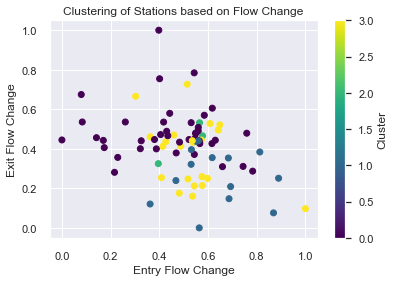

In [130]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

# 假设您已经有了包含进站和出站常态客流量的数据，保存在名为 "data.csv" 的CSV文件中
data = pd.read_csv('grouped.csv')
# 选择时间段6:00-22:00的数据
entry_data = data.iloc[:,1:25]

exit_data=data.iloc[:,25:]

# 计算每小时的变化趋势（差分）
diff_entry_data = entry_data.diff(axis=1).fillna(0)
diff_exit_data = exit_data.diff(axis=1).fillna(0)
# 进行每小时的归一化处理
scaler_entry = MinMaxScaler()
normalized_entry_data = scaler_entry.fit_transform(diff_entry_data)

scaler_exit = MinMaxScaler()
normalized_exit_data = scaler_exit.fit_transform(diff_exit_data)

# 组合为48列特征序列
feature_sequence = pd.concat([pd.DataFrame(normalized_entry_data), pd.DataFrame(normalized_exit_data)], axis=1)

# 使用K-Means算法进行聚类
kmeans = KMeans(n_clusters=4)  # 假设将站点聚类为5个簇
clusters = kmeans.fit_predict(feature_sequence)

# 输出每个站点所属的簇
for i, cluster in enumerate(clusters):
    print(f"站点{i}属于簇{cluster}")

# 绘制聚类散点图
plt.scatter(feature_sequence.iloc[:, 1], feature_sequence.iloc[:, 5], c=clusters, cmap='viridis')
plt.xlabel('Entry Flow Change')
plt.ylabel('Exit Flow Change')
plt.title('Clustering of Stations based on Flow Change')
plt.colorbar(label='Cluster')
plt.show()


<Figure size 7200x4800 with 0 Axes>

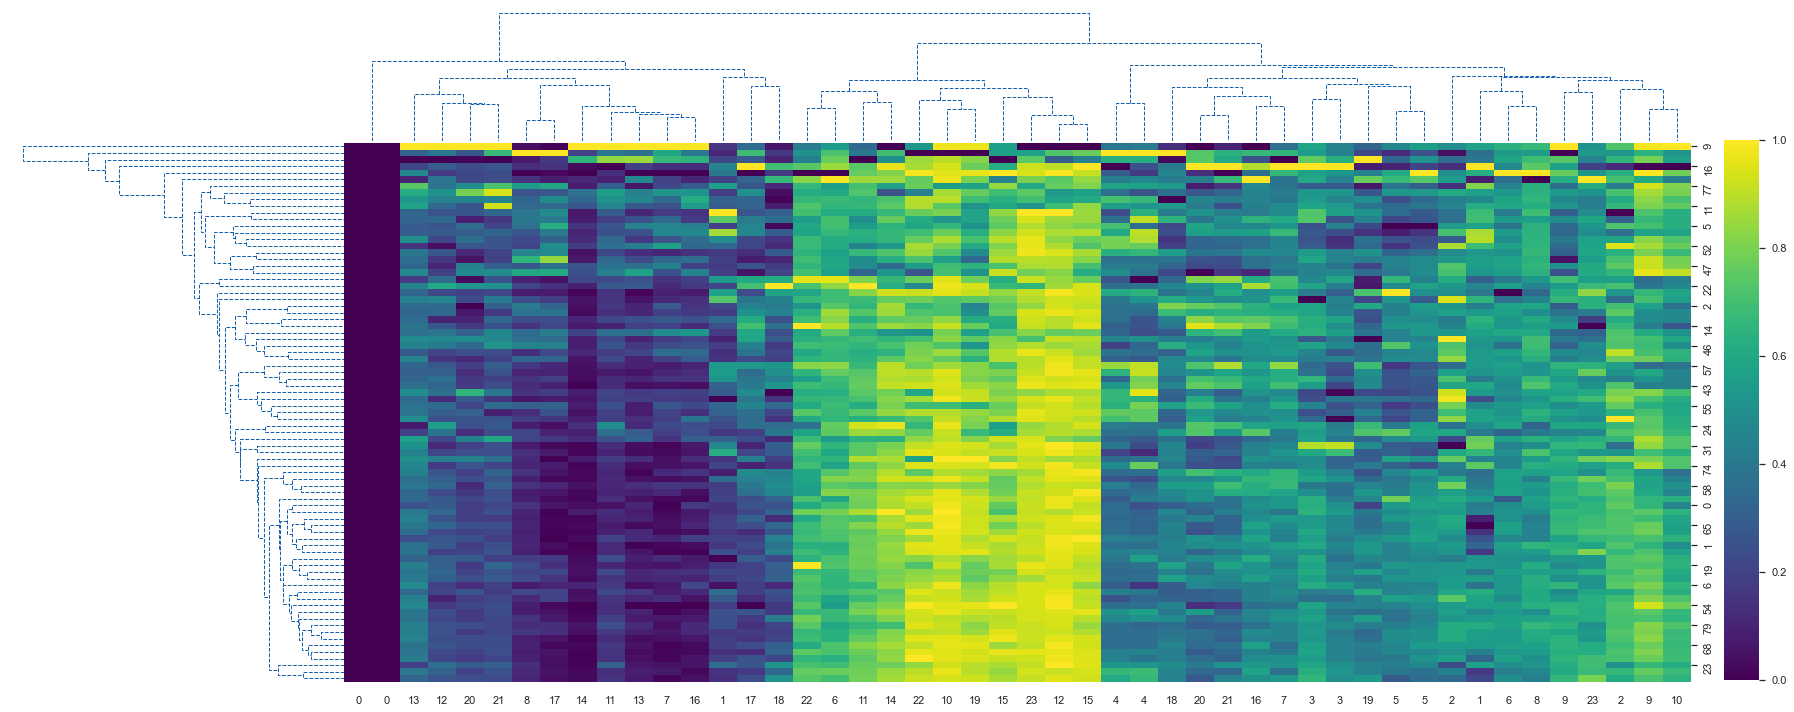

In [131]:
# 假设 feature_sequence 是一个 pandas DataFrame 对象
# # 获取原始列名
# original_columns = feature_sequence.columns

# # 修改列名
# new_columns = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48]

# # 更新 DataFrame 的列名
# feature_sequence.columns = new_columns

# # 打印修改后的列名
# print(feature_sequence.columns)

# feature_sequence = pd.DataFrame(feature_sequence)

# # 簇的数值数据
# cluster_data = [0, 0, 3, 3, 1, 1, 0, 1, 1, 2, 1, 1, 1, 3, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 3, 0, 3, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 1, 0, 0, 3, 3, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 3, 3, 3, 0, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0]

# # 将簇的数值数据添加为一列到 original_columns 中
# feature_sequence['class'] = cluster_data

# # 打印添加列后的矩阵
# print(original_columns)

result = feature_sequence.iloc[:, :48].copy()

plt.figure(dpi=1200)
sns.clustermap(data=result,
                figsize=(24,10),#热图宽和高
                cbar_pos=(1, 0.05, 0.02, 0.75), #(left, bottom, width, height)  
                cmap=plt.get_cmap('viridis'),
                tree_kws={'linestyles':'dashed',#线型
                        'colors':'#1661ab',#线色
                        'linewidths':1},#线宽 
            )

plt.savefig('clustermap.png', bbox_inches='tight')

In [132]:
feature_sequence

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.0,0.417675,0.560589,0.628812,0.345471,0.535181,0.492086,0.006923,0.143218,0.616988,...,0.035672,0.756592,0.171573,0.061092,0.298908,0.918898,0.180356,0.212574,0.909314,0.915489
1,0.0,0.325731,0.543855,0.598454,0.369219,0.440512,0.566036,0.016846,0.102113,0.631791,...,0.001321,0.873886,0.030863,0.034196,0.456348,0.912287,0.176933,0.241670,0.956199,0.919682
2,0.0,0.426538,0.514714,0.584259,0.373855,0.435821,0.583564,0.284111,0.413562,0.294554,...,0.036279,0.738172,0.150100,0.318944,0.810447,0.451269,0.000000,0.299460,0.665962,0.833739
3,0.0,0.362444,0.404645,0.547576,0.354178,0.460554,0.574804,0.116191,0.144733,0.579943,...,0.023237,0.825361,0.155249,0.051573,0.551711,0.861455,0.188644,0.315011,0.750701,0.859597
4,0.0,0.362156,0.038806,0.545186,1.000000,0.120682,0.547262,0.597412,1.000000,0.000000,...,0.193564,0.566511,0.400668,1.000000,1.000000,0.000000,0.267256,0.668951,0.000000,0.566786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,0.0,0.531777,0.705280,0.441462,0.482642,0.395736,0.555642,0.249817,0.587170,0.243585,...,0.247476,0.915839,0.448715,0.608394,0.220790,0.509691,0.466551,0.479556,0.260643,0.784274
77,0.0,0.812725,0.137190,0.281658,0.584417,0.383795,0.438917,0.211307,0.543972,0.360216,...,0.076110,0.840944,0.283798,0.598261,0.542024,0.571829,0.488569,0.712920,0.773369,0.600157
78,0.0,0.535200,1.000000,0.272242,0.448490,0.440938,0.525411,0.177072,0.361937,0.410111,...,0.085477,0.821957,0.212484,0.349951,0.424620,0.747380,0.488411,0.461250,0.695533,0.704778
79,0.0,0.616119,0.611368,0.520731,0.360511,0.426439,0.569495,0.038441,0.122644,0.638910,...,0.054337,0.905065,0.115824,0.140192,0.363583,0.825259,0.240805,0.208782,0.951147,0.916362


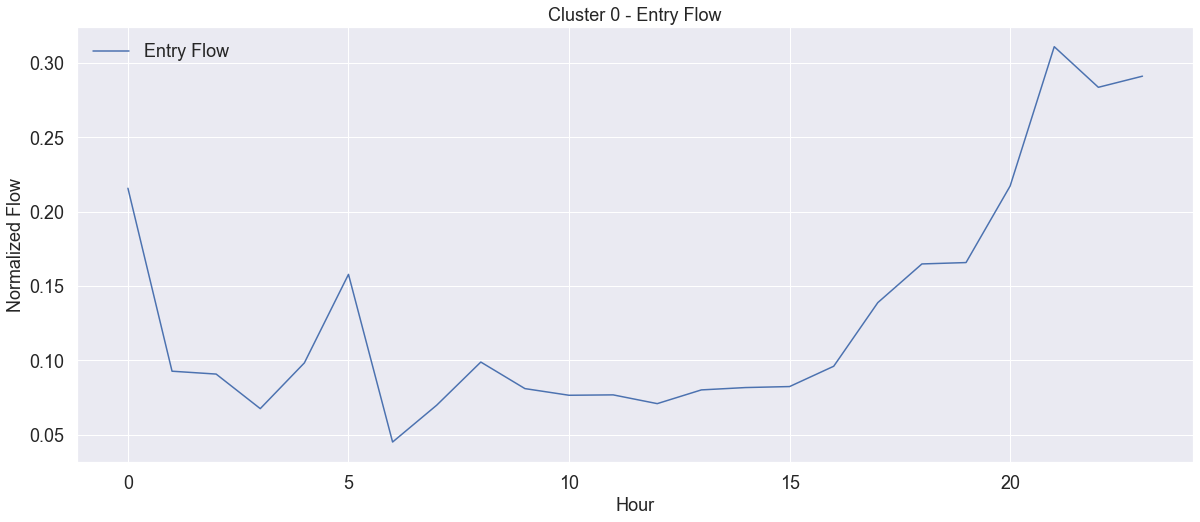

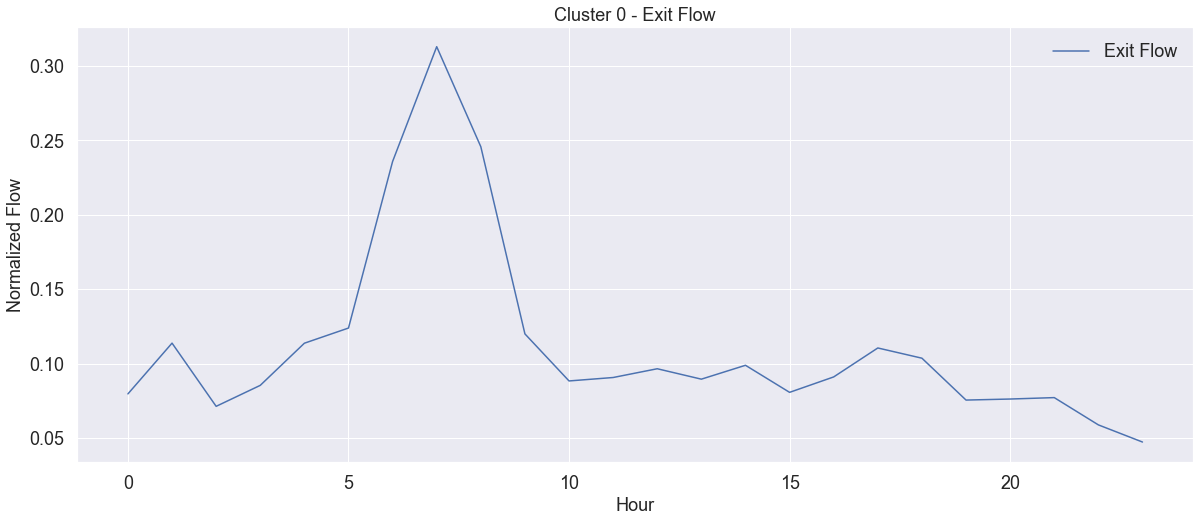

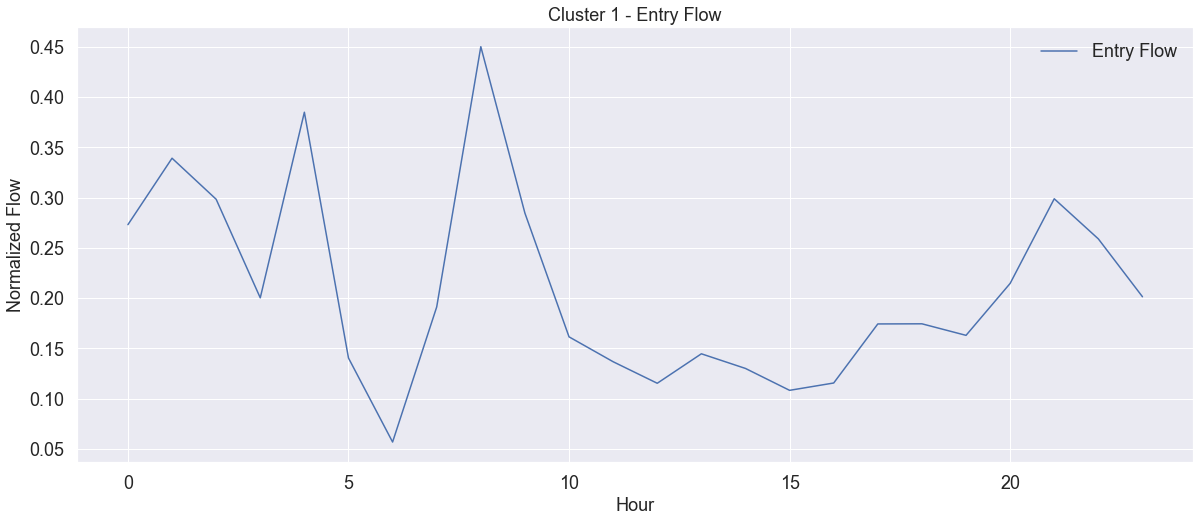

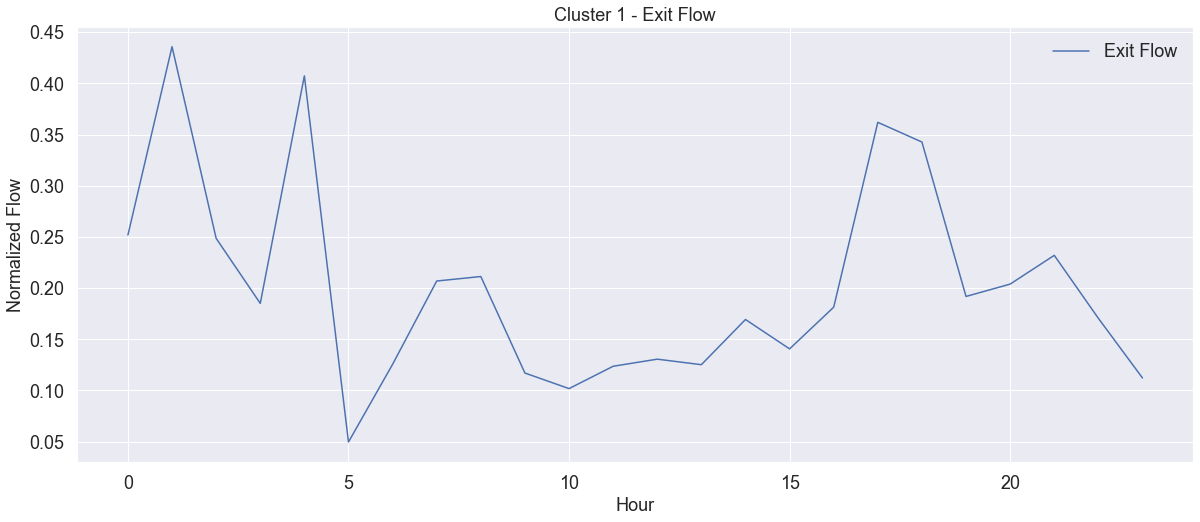

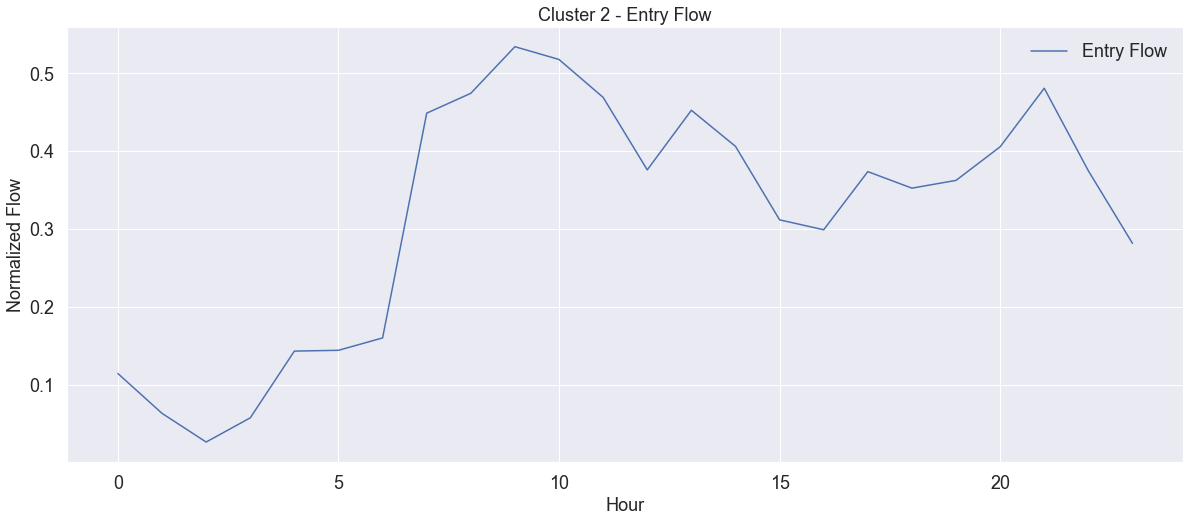

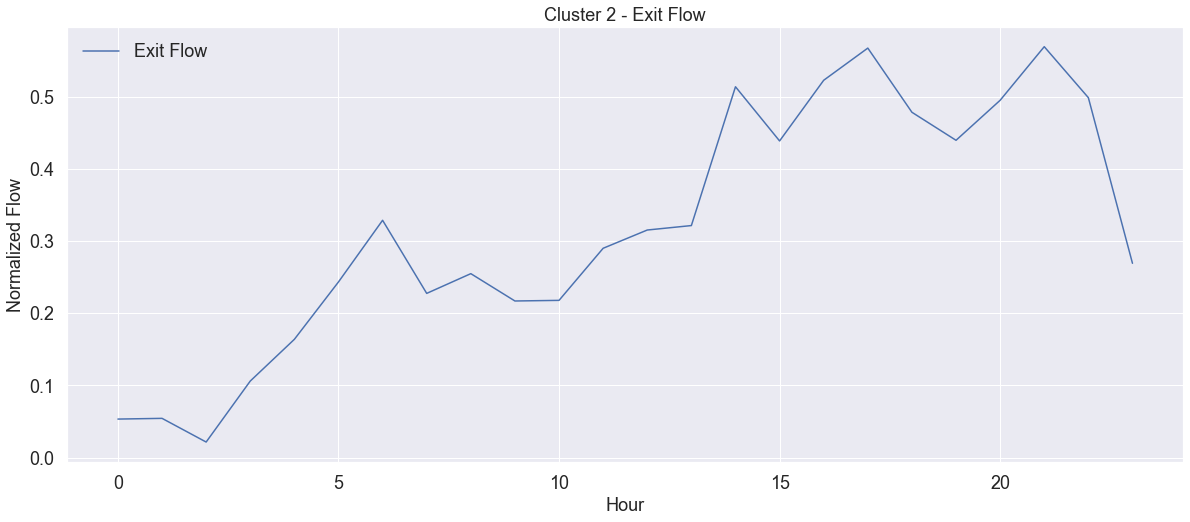

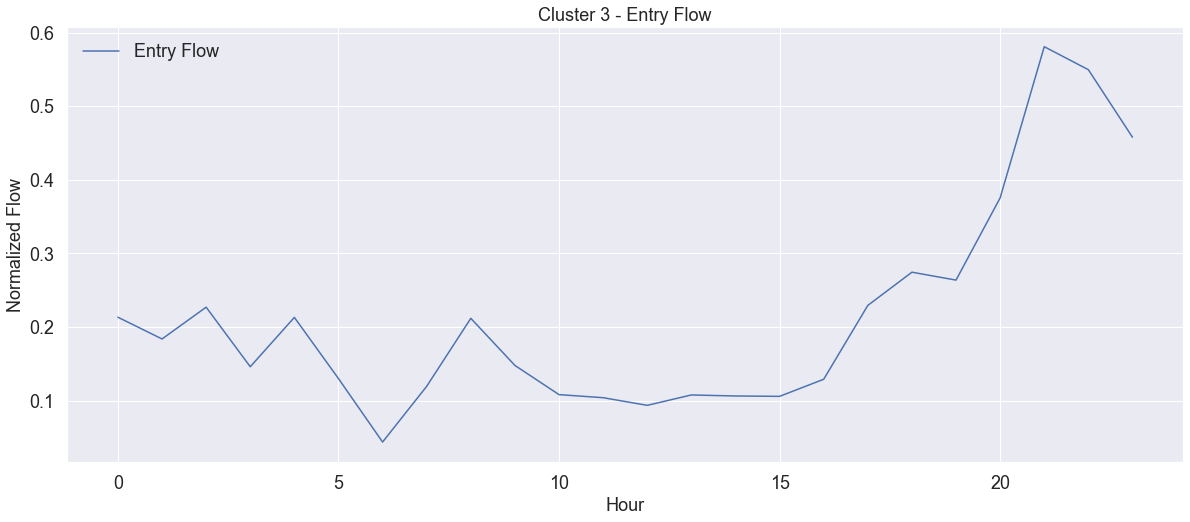

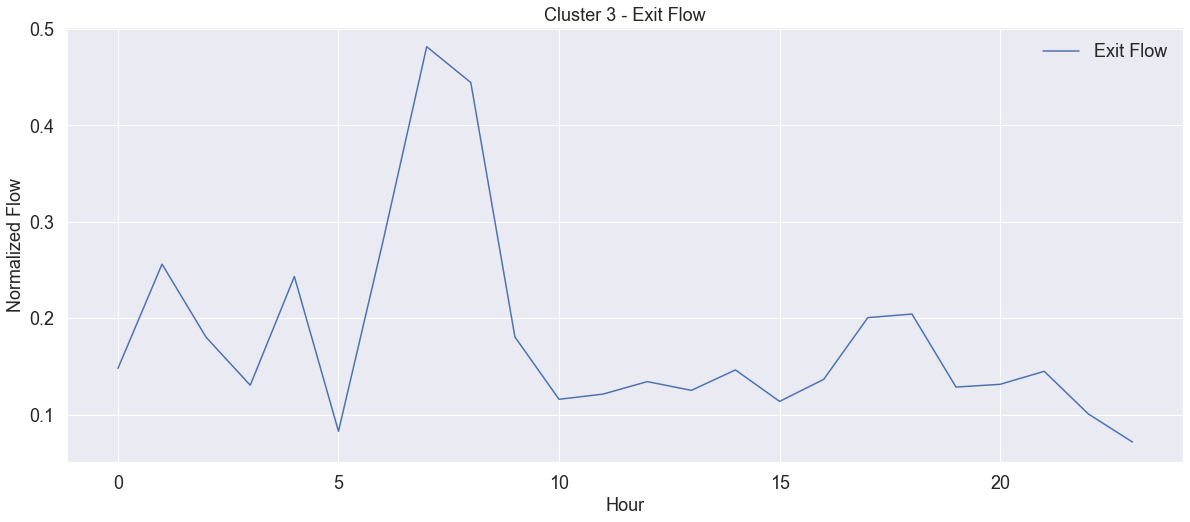

PermissionError: [Errno 13] Permission denied: 'kmeansdata.csv'

In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# 创建空的DataFrame用于保存数据
data = pd.DataFrame()

# 绘制进站和出战客流变化趋势图
for cluster_id in range(4):
    cluster_entry_data = entry_data[clusters == cluster_id]
    cluster_exit_data = exit_data[clusters == cluster_id]

    # 计算每个簇的平均值（可选）
    avg_cluster_entry_data = cluster_entry_data.mean(axis=0)
    avg_cluster_exit_data = cluster_exit_data.mean(axis=0)

    # 添加进站和出站数据到DataFrame
    cluster_data = pd.DataFrame({
        'Hour': range(48),
        f'Cluster {cluster_id} - Entry Flow': avg_cluster_entry_data,
        f'Cluster {cluster_id} - Exit Flow': avg_cluster_exit_data
    })

    # 将当前簇的数据添加到整体数据中
    data = pd.concat([data, cluster_data], axis=1)
    # data = data.append(cluster_data, ignore_index=True)


    # 绘制进站客流变化趋势图
    plt.figure(figsize=(20,8))
    plt.plot(range(24), avg_cluster_entry_data, label='Entry Flow')
    plt.xlabel('Hour', fontsize=18)
    plt.ylabel('Normalized Flow', fontsize=18)
    plt.title(f'Cluster {cluster_id} - Entry Flow', fontsize=18)
    plt.legend()
    # 设置横轴和纵轴的字号大小
    plt.xticks(fontsize=18)  # 设置横轴刻度标签字号大小为12
    plt.yticks(fontsize=18)  # 设置纵轴刻度标签字号大小为12 
    plt.legend(fontsize=18)  # 设置图例字号大小为12
    plt.savefig(f'cluster_{cluster_id}_entry.png')  # 保存进站客流图像
    plt.show()


    # 绘制出站客流变化趋势图
    plt.figure(figsize=(20,8))
    plt.plot(range(24), avg_cluster_exit_data, label='Exit Flow')
    plt.xlabel('Hour', fontsize=18)
    plt.ylabel('Normalized Flow', fontsize=18)
    plt.title(f'Cluster {cluster_id} - Exit Flow', fontsize=18)
    plt.legend()
    # 设置横轴和纵轴的字号大小
    plt.xticks(fontsize=18)  # 设置横轴刻度标签字号大小为12
    plt.yticks(fontsize=18)  # 设置纵轴刻度标签字号大小为12 
    plt.legend(fontsize=18)  # 设置图例字号大小为12
    plt.savefig(f'cluster_{cluster_id}_exit.png')  # 保存出站客流图像
    plt.show()

# 将数据保存到CSV文件
data.to_csv('kmeansdata.csv', index=False)

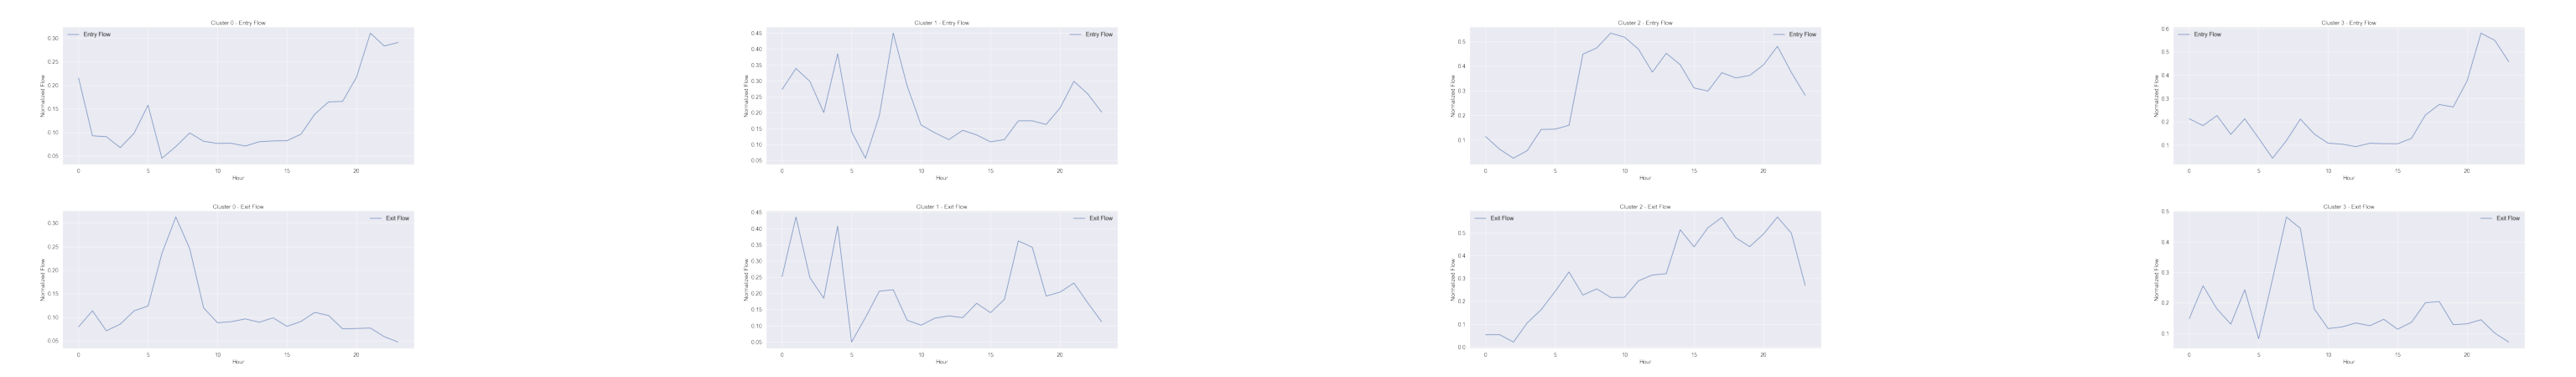

In [163]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# 创建一个 2x4 的子图布局
fig, axs = plt.subplots(2, 4, figsize=(60,8))

# 遍历每个簇的编号
for cluster_id in range(4):
    # 获取对应的图片路径
    entry_img_path = f'cluster_{cluster_id}_entry.png'
    exit_img_path = f'cluster_{cluster_id}_exit.png'

    # 读取图片并在对应的子图中显示
    entry_img = mpimg.imread(entry_img_path)
    exit_img = mpimg.imread(exit_img_path)
    axs[0, cluster_id].imshow(entry_img)
    axs[1, cluster_id].imshow(exit_img)

    # 隐藏坐标轴和刻度
    axs[0, cluster_id].axis('off')
    axs[1, cluster_id].axis('off')

# 调整子图之间的间距
plt.subplots_adjust(wspace=0.01, hspace=0.01)

# 保存拼接后的图片
plt.savefig('combined_images.png')


In [141]:
entry_data[clusters == 0]

,out_0,out_1,out_2,out_3,out_4,out_5,out_6,out_7,out_8,out_9,...,out_14,out_15,out_16,out_17,out_18,out_19,out_20,out_21,out_22,out_23
0,0.146444,0.000000,0.009901,0.045977,0.039062,0.173077,0.034596,0.037333,0.081457,0.066788,...,0.093322,0.092364,0.106222,0.157953,0.175088,0.149568,0.196680,0.283473,0.227125,0.242251
1,0.238494,0.000000,0.000000,0.011494,0.023438,0.024038,0.012817,0.019477,0.032750,0.025917,...,0.031255,0.036047,0.050989,0.096402,0.138878,0.149625,0.223896,0.372025,0.325649,0.301337
6,0.330544,0.146552,0.148515,0.172414,0.125000,0.134615,0.071618,0.097771,0.089970,0.094705,...,0.091538,0.078062,0.084883,0.121615,0.110454,0.109926,0.179834,0.290617,0.277616,0.205347
15,0.066946,0.120690,0.089109,0.080460,0.031250,0.264423,1.000000,1.000000,0.936633,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.922865,0.605221,0.538164
17,0.046025,0.112069,0.138614,0.000000,0.062500,0.067308,0.010905,0.041731,0.140609,0.054613,...,0.043458,0.043684,0.049684,0.087895,0.105029,0.125588,0.160816,0.230333,0.219569,0.197792
19,0.041841,0.008621,0.000000,0.000000,0.000000,0.129808,0.035259,0.056199,0.167289,0.077441,...,0.067902,0.063132,0.077462,0.117113,0.144579,0.141014,0.196965,0.379432,0.489451,0.416602
21,0.046025,0.025862,0.019802,0.011494,0.101562,0.004808,0.007591,0.032936,0.080192,0.061393,...,0.035137,0.032719,0.040311,0.073632,0.123733,0.136871,0.178856,0.273612,0.292669,0.289035
23,0.221757,0.224138,0.039604,0.045977,0.187500,0.168269,0.025846,0.045198,0.078608,0.066709,...,0.062521,0.068911,0.085078,0.137134,0.209036,0.210063,0.270199,0.423040,0.409387,0.449535
25,0.171548,0.008621,0.039604,0.011494,0.023438,0.466346,0.034160,0.107150,0.200922,0.101437,...,0.112606,0.106201,0.142379,0.178990,0.226515,0.256960,0.384102,0.543937,0.478606,0.369237
26,0.355649,0.051724,0.019802,0.000000,0.062500,0.197115,0.018104,0.058232,0.076181,0.042376,...,0.057603,0.071871,0.092640,0.131637,0.186678,0.192216,0.274515,0.399702,0.380823,0.406238
